In [1]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pickle

# RNNs as a generative model

In [131]:
# load and preprocess the MNIST dataset
def load_and_preprocess_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    return x_train, y_train, x_test, y_test

In [132]:
x_train, y_train, x_test, y_test = load_and_preprocess_data()

In [133]:
x_train.shape

(60000, 28, 28)

In [134]:
x_test.shape

(10000, 28, 28)

### Patch generation and architecture

In [135]:
def create_patches(img):
    img = tf.expand_dims(img, axis=0)
    img = tf.expand_dims(img, axis = -1)

    res = tf.image.extract_patches(images = img,
                                   sizes=[1, 7, 7, 1],
                                   strides=[1, 7, 7, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')

    patches = tf.reshape(res, shape=(16,7,7))
    return patches

In [136]:
image_patches = []
for i in range(x_train.shape[0]):
    image_patches.append(create_patches(x_train[i,:,:]))
image_patches_tr = np.array(image_patches)

In [137]:
image_patches_tr.shape

(60000, 16, 7, 7)

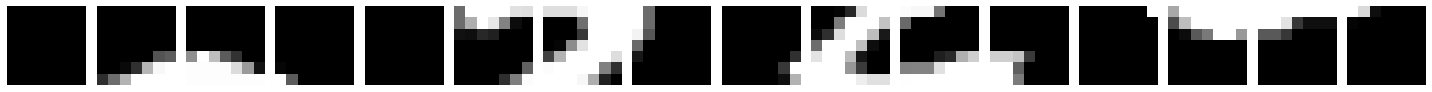

In [138]:
fig, ax = plt.subplots(1, 16, figsize=(20, 5))  # Adjust the figsize for better layout
for i in range(4):
    for j in range(4):
        idx = 4 * i + j
        ax[idx].imshow(image_patches_tr[25][idx], cmap='gray')  # Add cmap='gray'
        ax[idx].axis('off')  # Turn off axis information
plt.tight_layout()
plt.show()

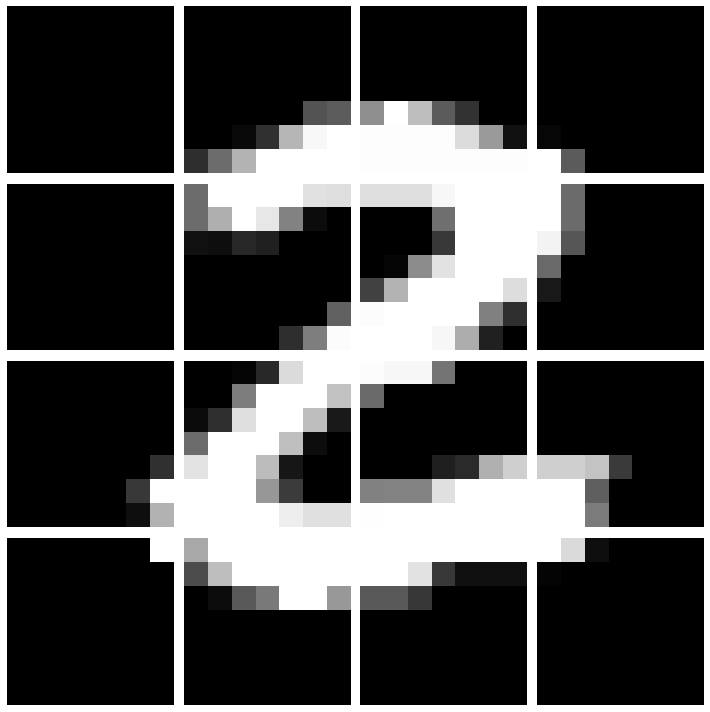

In [139]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        idx = 4 * i + j
        ax[i, j].imshow(image_patches_tr[25][idx], cmap='gray')  # Add cmap='gray'
        ax[i, j].axis('off')  # Turn off axis information

plt.tight_layout()
plt.show()

In [140]:
# flatten patches
vec_patches_tr = image_patches_tr.reshape(x_train.shape[0], -1, 49)

In [141]:
vec_patches_tr.shape

(60000, 16, 49)

In [142]:
x_tr_patch = image_patches_tr[:,:15,:]
x_tr_patch = tf.reshape(x_tr_patch, shape=(x_train.shape[0], -1, 49))

In [143]:
x_tr_patch.shape

TensorShape([60000, 15, 49])

In [144]:
y_tr_patch = image_patches_tr[:,1:16,:]
y_tr_patch = tf.reshape(y_tr_patch, shape=(x_train.shape[0], -1, 49))

In [145]:
y_tr_patch.shape

TensorShape([60000, 15, 49])

In [146]:
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh'),
        tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh'),
        tf.keras.layers.Dense(49, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

In [147]:
lstm_model = create_lstm_model(input_shape=(None, 49))
lstm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, None, 64)       │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, None, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, 49)       │         3,185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,393 (255.44 KB)

 Trainable params: 65,393 (255.44 KB)

 Non-trainable params: 0 (0.00 B)

### Training loop and convergence

In [148]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [149]:
lstm_history = lstm_model.fit(x_tr_patch, y_tr_patch, batch_size=100, epochs=100, validation_split=0.2, callbacks=callback)

Epoch 1/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0824 - val_loss: 0.0505
Epoch 2/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0484 - val_loss: 0.0434
Epoch 3/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0428 - val_loss: 0.0404
Epoch 4/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0401 - val_loss: 0.0385
Epoch 5/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0385 - val_loss: 0.0373
Epoch 6/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0370 - val_loss: 0.0365
Epoch 7/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0361 - val_loss: 0.0356
Epoch 8/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0353 - val_loss: 0.0350
Epoch 9/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0348 - val_loss: 0.0345
Epoch 10/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0343 - val_loss: 0.0340
Epoch 11/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0338 - val_loss: 0.0336
Epoch 12/100
480/480 ━━━━━━━━━━━━━━━━━━━━

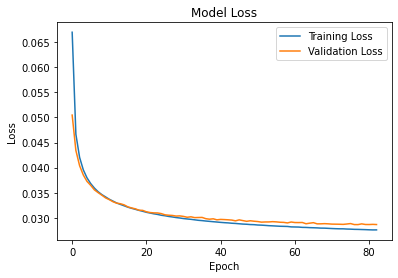

In [150]:
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Final image generation

In [151]:
y_sample = []
for i in range(x_test.shape[0]):
    y_sample.append(create_patches(x_test[i,:,:]))
y_sample_tr = np.array(y_sample)
print(y_sample_tr.shape)

(10000, 16, 7, 7)


In [152]:
# flatten
y_sample = tf.reshape(y_sample_tr, shape=(x_test.shape[0], 16, 49))
print(y_sample.shape)

(10000, 16, 49)


In [153]:
patches = y_sample[0][:8,:]
print(patches.shape)

(8, 49)


In [154]:
patches = tf.expand_dims(patches, axis=0)
for i in range(8):
    predictions = model.predict(patches)
    patches = np.concatenate((patches, predictions[:,-1,:].reshape(1,1,49)), axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [155]:
patches.shape

(1, 16, 49)

In [156]:
# original test images 
img_index = np.zeros((100, 28, 28))
ten_index = []
for i in range(0, 10):
    index = np.where(y_test == i)
    for i in range(10):
        ten_index.append(index[0][i])
for i in range(10):
    for j in range(10):
        img_index[i*10+j] = x_test[ten_index[i*10+j]]

In [157]:
img_index.shape

(100, 28, 28)

#### Original images

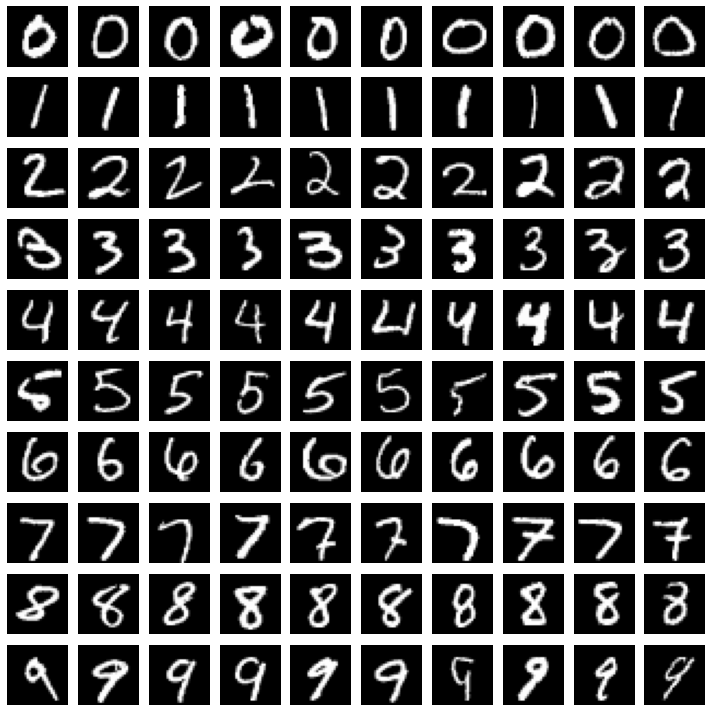

In [158]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):        
        ax[i][j].imshow(img_index[i*10+j], cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

In [159]:
img_patches = []
for i in range(img_index.shape[0]):
    img_patches.append(create_patches(img_index[i,:,:]))
img_index_patches = np.array(img_patches)
print(img_index_patches.shape)

(100, 16, 7, 7)


In [160]:
img_index_patches = tf.reshape(img_index_patches, shape=(100, 16, 49))

In [161]:
def generate_images(img):
    predictions = img[0:8,:].numpy().reshape(1, 8, 49)
    for i in range(8):
        y_pred = lstm_model.predict(predictions)
        predictions = np.concatenate((predictions, y_pred[:,-1,:].reshape(1,1,49)), axis = 1)
    return predictions

In [162]:
generated_images = np.zeros((100, 16, 49))

for i in range(10):
    for j in range(10):
        generated_images[i*10+j] = generate_images(img_index_patches[i*10+j])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

In [163]:
generated_images.shape

(100, 16, 49)

In [164]:
def reshape_image(img):
    reshaped_img = np.zeros((28,28))
    count = 0
    img = np.expand_dims(img,axis=0)
    for i in range(4):
        for j in range(4):
            reshaped_img[i*7:i*7+7,j*7:j*7+7] = img[0,count].reshape(7,7)
            count+=1
    return(reshaped_img)

In [165]:
reshaped_images = np.zeros((100,28,28))
for i in range(10):
    for j in range(10):
        reshaped_images[i*10+j] = reshape_image(generated_images[i*10+j])

#### Generated images

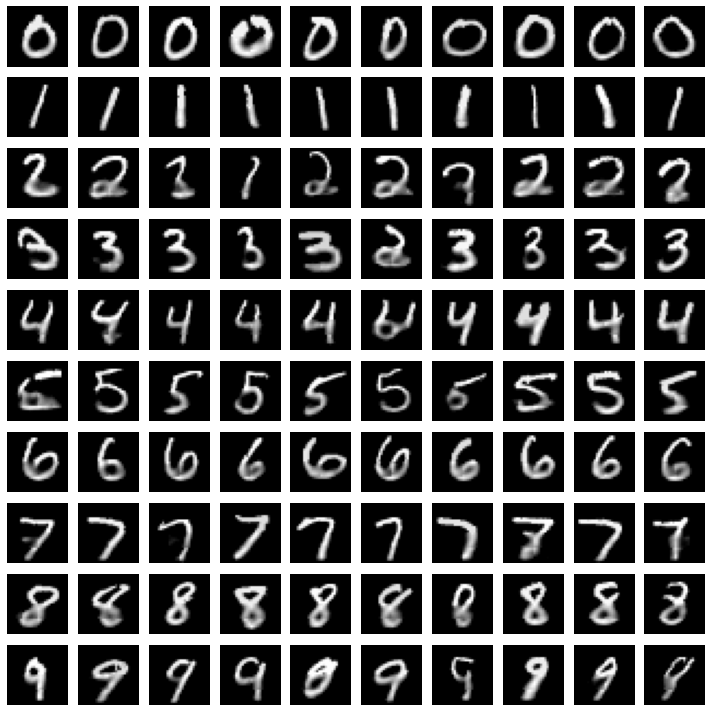

In [166]:
fig, ax = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(reshaped_images[i*10+j], cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()